In [2]:
import rioxarray
import numpy as np
import pandas as pd
from datascience import *   
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
import joblib
from scipy.stats import uniform
from xgboost import plot_importance
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

In [3]:
HEIGHT = 90
WIDTH = 250
# all_data = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m4_y19 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m10_y19 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m4_y20 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m10_y20 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
cordinates = {}
tmp_name = ['AWS', 'CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']
file_name = [['Precipitation','AWS']]
opt_file_name = ['AWS', 'CAPE', 'CIN', 'V850', 'KX', 'R250', 'R500', 'U250', 'U850', 'EWSS']
opt_file_name_path = [['Precipitation','AWS']]
for i in range(1,len(tmp_name)):
    file_name.append(['ERA5',tmp_name[i]])
for i in range(1,len(opt_file_name)):
    opt_file_name_path.append(['ERA5',opt_file_name[i]])
# file_name

Hàm lấy các tọa độ có dữ liệu AWS

In [10]:
def get_AWS_cordinates(hour_list, day_list, month_list, year_list, cordinates):
    for year in year_list:
        for month in month_list:
            for day in day_list:
                for hour in hour_list:
                    file_path = f'DATA_SV/Precipitation/AWS/{year}/{month:02}/{day:02}/AWS_{year}{month:02}{day:02}{hour:02}0000.tif'
                    path = Path(file_path)
                    if not path.is_file():
                        continue
                    dataset = rioxarray.open_rasterio(file_path)
                    data = dataset[0].values
                    for i in range(HEIGHT):
                        for j in range(WIDTH):
                            if data[i][j] != -np.inf:
                                cordinates[(i,j)] = True
                                # print(i,j)
    cordinates = sorted(cordinates)

Hàm đọc dữ liệu

In [12]:

def read(hour, day, month, year, file, cordinates, all_data):
    data = []
    for i in range(len(file)):
        name1 = file[i][0]
        name2 = file[i][1]
        file_path = f'DATA_SV/{name1}/{name2}/{year}/{month:02}/{day:02}/{name2}_{year}{month:02}{day:02}{hour:02}0000.tif'
        # print(file_path)
        path = Path(file_path)
        if not path.is_file():
            return
        # print(file_path)
        dataset = rioxarray.open_rasterio(file_path)
        data.append(dataset[0].values)
        
    # print(len(data))
    if(data != []): 
        for pos in cordinates:
            i = pos[0]
            j = pos[1]
            check = True
            tmp = [datetime(year,month,day,hour)]
            for z in range(len(data)):
                if(data[z][i][j] == -np.inf or data[z][i][j] == np.inf or data[z][i][j] == np.nan):
                    check = False
                    break
                tmp.append(data[z][i][j])
            if check:
                all_data[i][j].append(tmp)
                # print(all_data[i][j])
    # print(all_data)
            

Đọc dự liệu trong khoảng thời gian định sẵn tại đây. dữ liệu all_data[i][j][z] là tại vị trí i, j có tập giá trị tương ứng tại cùng thời điểm

In [6]:

for i in range(HEIGHT):
    for j in range(WIDTH):
        m4_y19[i][j] = []
        m10_y19[i][j] = []
        m4_y20[i][j] = []
        m10_y20[i][j] = []
cordinates.clear
# hour = [0]
hour = [i for i in range(24)]
# day = [1]
# day = [i for i in range(27,28)]
day = [i for i in range(1,32)]
# month = [4]
month = [4,10]
# year = [2019] 
year = [2019,2020]
get_AWS_cordinates(hour, day, month, year, cordinates)
cordinates_list = list(cordinates)
for k in day:
    for l in hour:
        read(l, k, month[0], year[0], file_name, cordinates_list, m4_y19)
        read(l, k, month[1], year[0], file_name, cordinates_list, m10_y19)
        read(l, k, month[0], year[1], file_name, cordinates_list, m4_y20)
        read(l, k, month[1], year[1], file_name, cordinates_list, m10_y20)
# print(len(cordinates_list))

In [100]:
all_data = []
for (i,j) in cordinates_list:
    for data in m4_y19[i][j]:
        all_data.append([i,j] + data)
    for data in m10_y19[i][j]:
        all_data.append([i,j] + data)
    for data in m4_y20[i][j]:
        all_data.append([i,j] + data)
    for data in m10_y20[i][j]:
        all_data.append([i,j] + data)
print((all_data[0]))
    

[0, 114, datetime.datetime(2019, 4, 1, 0, 0), 0.0, 446.125, 38.875008, -641.11328, -1.3912562e-05, 0.58824843, 37.360176, -1.5529804e-05, 33.599831, 39.494701, 94.882187, -127783.0, 0.019672839, -11962.0, 0.72320557, 49.239563, 48.219376, 25.793488, -3.6066742, 4.5234528, 7.3280945]


Tải dữ liệu ra csv

In [135]:
print(len(all_data[0]))
df = pd.DataFrame(all_data, columns=['row','column','time'] + tmp_name)
df.to_csv('data.csv', index=False)

24


Nếu đã có file data.csv thì đọc từ đây

In [4]:
data_csv = pd.read_csv('data.csv')
# opt_data_csv = data_csv[['row','column','time']+opt_file_name]
opt_data_csv = data_csv[['row','column','time']+ opt_file_name]
all_data = opt_data_csv.values
# all_data = np.array(all_data)
for i in range(len(all_data)):    
    all_data[i][2] = datetime.strptime(all_data[i][2], '%Y-%m-%d %H:%M:%S')
opt_data_csv.head()
# all_data

,row,column,time,AWS,CAPE,CIN,V850,KX,R250,R500,U250,U850,EWSS
0,0,114,2019-04-01 00:00:00,0.0,446.125,38.8750,7.32809,37.3602,33.59980,39.49470,25.7935,-3.60667,-641.1130
1,0,114,2019-04-01 02:00:00,9.2,519.750,73.3129,7.41515,36.5532,10.45720,14.25490,30.9666,-2.22687,-201.3910
2,0,114,2019-04-01 03:00:00,7.4,447.500,112.0940,7.14874,34.9319,9.48545,8.98339,30.6357,-2.50978,-80.8945
3,0,114,2019-04-01 04:00:00,0.0,421.500,158.5940,7.31476,32.5174,8.68878,9.59861,30.3324,-2.59560,-33.9180
4,0,114,2019-04-01 05:00:00,0.0,435.625,98.8282,7.58484,31.7187,8.34901,9.43200,30.1800,-2.81416,11.6406


In [101]:
for data in all_data:  
    if data[0] == 0 and data[1] == 104:
        print('yes')

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


Xây dựng bộ dữ liệu X,y để cho vào mô hình. 

In [5]:
def create_data(all_data, X, y, num_pre, num_data):
    for z in range(num_pre,int(len(all_data))-num_data+1):
        data = all_data[z:z+num_data]  
        pre_data = all_data[z-num_pre:z]
        check = True
        for k in range(z-num_pre,z+num_data):
            # print(all_data[k])
            if (all_data[k][2] - all_data[k-1][2]).total_seconds() == 3600:
                check = False
                break
        if check:
            continue
        
        # print(len(pre_data),len(data))
        pre_data = np.array(pre_data)
        data = np.array(data)
        
        # print(pre_data.shape,data.shape)
        
        pre_data = pre_data[:,3:].reshape(-1)
        data = data[:,3].reshape(-1)

        
        X.append(pre_data)
        y.append(data)
        # print(pre_data[2:],data[1])

In [6]:
pre_time_step = 3
aft_time_step = 6

In [14]:
X_train = []
y_train = []
X_test = []
y_test = []

X = []
y = []
create_data(all_data, X, y, pre_time_step, aft_time_step)
X = np.array(X)
y = np.array(y)
# X, y = resample(X, y,  replace=False, n_samples=10000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(525526, 30)
(525526, 6)
(131382, 30)
(131382, 6)


In [9]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

param_dist = {
    'learning_rate': [0.01,0.03,0.05,0.07, 0.09,0.1],
    'max_depth': [14, 16, 18, 20, 22, 24, 26, 28, 30],
    'n_estimators': [100, 125, 150, 175, 200],
    'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [ 0.6,0.7, 0.8,0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
}

random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

# grid_search = GridSearchCV(
#     xgb_model, 
#     param_distributions=param_dist, 
#     scoring='neg_mean_squared_error',
#     cv=3, 
#     verbose=2, 
#     random_state=42,
# )

# print(random_search)

In [ ]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  11.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=   9.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=   9.8s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.07, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=   6.8s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.07, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.07, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=   6.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          n_jobs=None, num_parallel_tree=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.07, 0.09, 0.1],
                                        'max_depth': [14, 16, 18, 20, 22, 24,
                                                      26, 28, 30],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7],
                                        'n_estimators': [100, 125, 150, 175,
                                                         200],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [23]:
print(random_search.best_params_)

{'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.029171739493308188, 'max_depth': 17, 'min_child_weight': 5, 'n_estimators': 125, 'subsample': 0.6}


In [25]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=3, n_estimators=150, subsample=0.8; total time= 3.9min
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=3, n_estimators=150, subsample=0.8; total time= 3.7min
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=3, n_estimators=150, subsample=0.8; total time= 3.7min
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.01, max_depth=14, min_child_weight=5, n_estimators=150, subsample=0.8; total time= 2.1min
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.01, max_depth=14, min_child_weight=5, n_estimators=150, subsample=0.8; total time= 2.1min
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.01, max_depth=14, min_child_weight=5, n_estimators=150, subsample=0.8; total time=25.4min
[CV] END colsample_bytree=0.6, gamma=0.1, learning_

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [14, 16, 18],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 125, 150],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [27]:
print(grid_search.best_params_)

{'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


In [13]:
# plot_importance(xgb_model, importance_type='weight', max_num_features=21, title='Feature Importance')
# importance = xgb_model.get_booster().get_score(importance_type='weight')
# new_importance = {}
# for i,(key, value) in enumerate(importance.items()):
#     feature_name = f'{tmp_name[int(key[1:]) % 21]}'
#     new_importance[feature_name] = new_importance.get(feature_name, 0) + value
# importance = new_importance
# sorted_importance = np.array(sorted(importance.items(), key=lambda item: item[1], reverse=True) )
# plt.figure(figsize=(30,20))
# plt.barh(sorted_importance[:,0],sorted_importance[:,1])
# print(sorted_importance[0][1])
# for (key, value) in sorted_importance:
#     print(key, value)
y_pred = random_search.predict(X_test)
load_model = xgb_model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error:", mae)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Percentage Error:", mae)
r2 = r2_score(y_test,y_pred)
print("R-squared:", r2)


Mean Squared Error: 4.021127223968506
Mean Absolute Error: 0.48725929856300354
Mean Absolute Percentage Error: 0.48725929856300354
R-squared: 0.2080410122871399


Lưu mô hình

In [ ]:
joblib.dump(random_search, 'model36.pkl')

['model.pkl']

In [15]:
load_model = joblib.load('model36.pkl')

In [16]:

y_pred = load_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error:", mae)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Percentage Error:", mae)
r2 = r2_score(y_test,y_pred)
print("R-squared:", r2)

print(load_model.best_params_)

Mean Squared Error: 2.9787044525146484
Mean Absolute Error: 0.3481936752796173
Mean Absolute Percentage Error: 0.3481936752796173
R-squared: 0.4406168460845947
{'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.029171739493308188, 'max_depth': 17, 'min_child_weight': 5, 'n_estimators': 125, 'subsample': 0.6}


nan
0 104
0 106
0 114
0 116
0 118
0 119
0 120
0 122
0 125
0 127
0 128
0 137
1 74
1 91
1 102
1 117
1 119
1 120
1 121
1 132
1 149
1 150
2 79
2 99
2 101
2 106
2 107
2 118
2 120
2 121
2 122
2 123
2 130
2 146
2 156
3 55
3 64
3 74
3 85
3 115
3 118
3 120
3 121
3 145
3 150
4 57
4 85
4 93
4 99
4 111
4 117
4 121
4 125
4 130
4 141
4 144
4 145
5 104
5 106
5 109
5 114
5 121
5 157
5 162
6 86
6 95
6 112
6 116
6 118
6 124
6 130
6 133
7 67
7 108
7 109
7 115
7 127
8 88
8 96
8 99
8 100
8 111
8 122
9 101
9 102
9 106
9 108
9 109
9 119
9 120
9 131
9 133
9 150
10 98
10 107
10 108
10 113
10 117
10 128
10 134
10 136
11 94
11 105
11 106
11 116
11 124
12 96
12 107
12 116
12 117
12 119
12 134
13 98
13 104
13 110
13 111
13 115
13 120
13 132
13 137
14 87
14 90
14 93
14 127
14 130
14 134
14 136
15 100
15 110
15 115
15 138
16 96
16 105
16 109
16 110
16 135
17 115
17 118
17 132
18 98
18 102
18 116
18 134
18 139
19 108
19 112
19 113
19 126
20 91
20 103
20 104
20 135
21 98
21 102
21 109
21 129
22 103
22 111
23 101
23 11

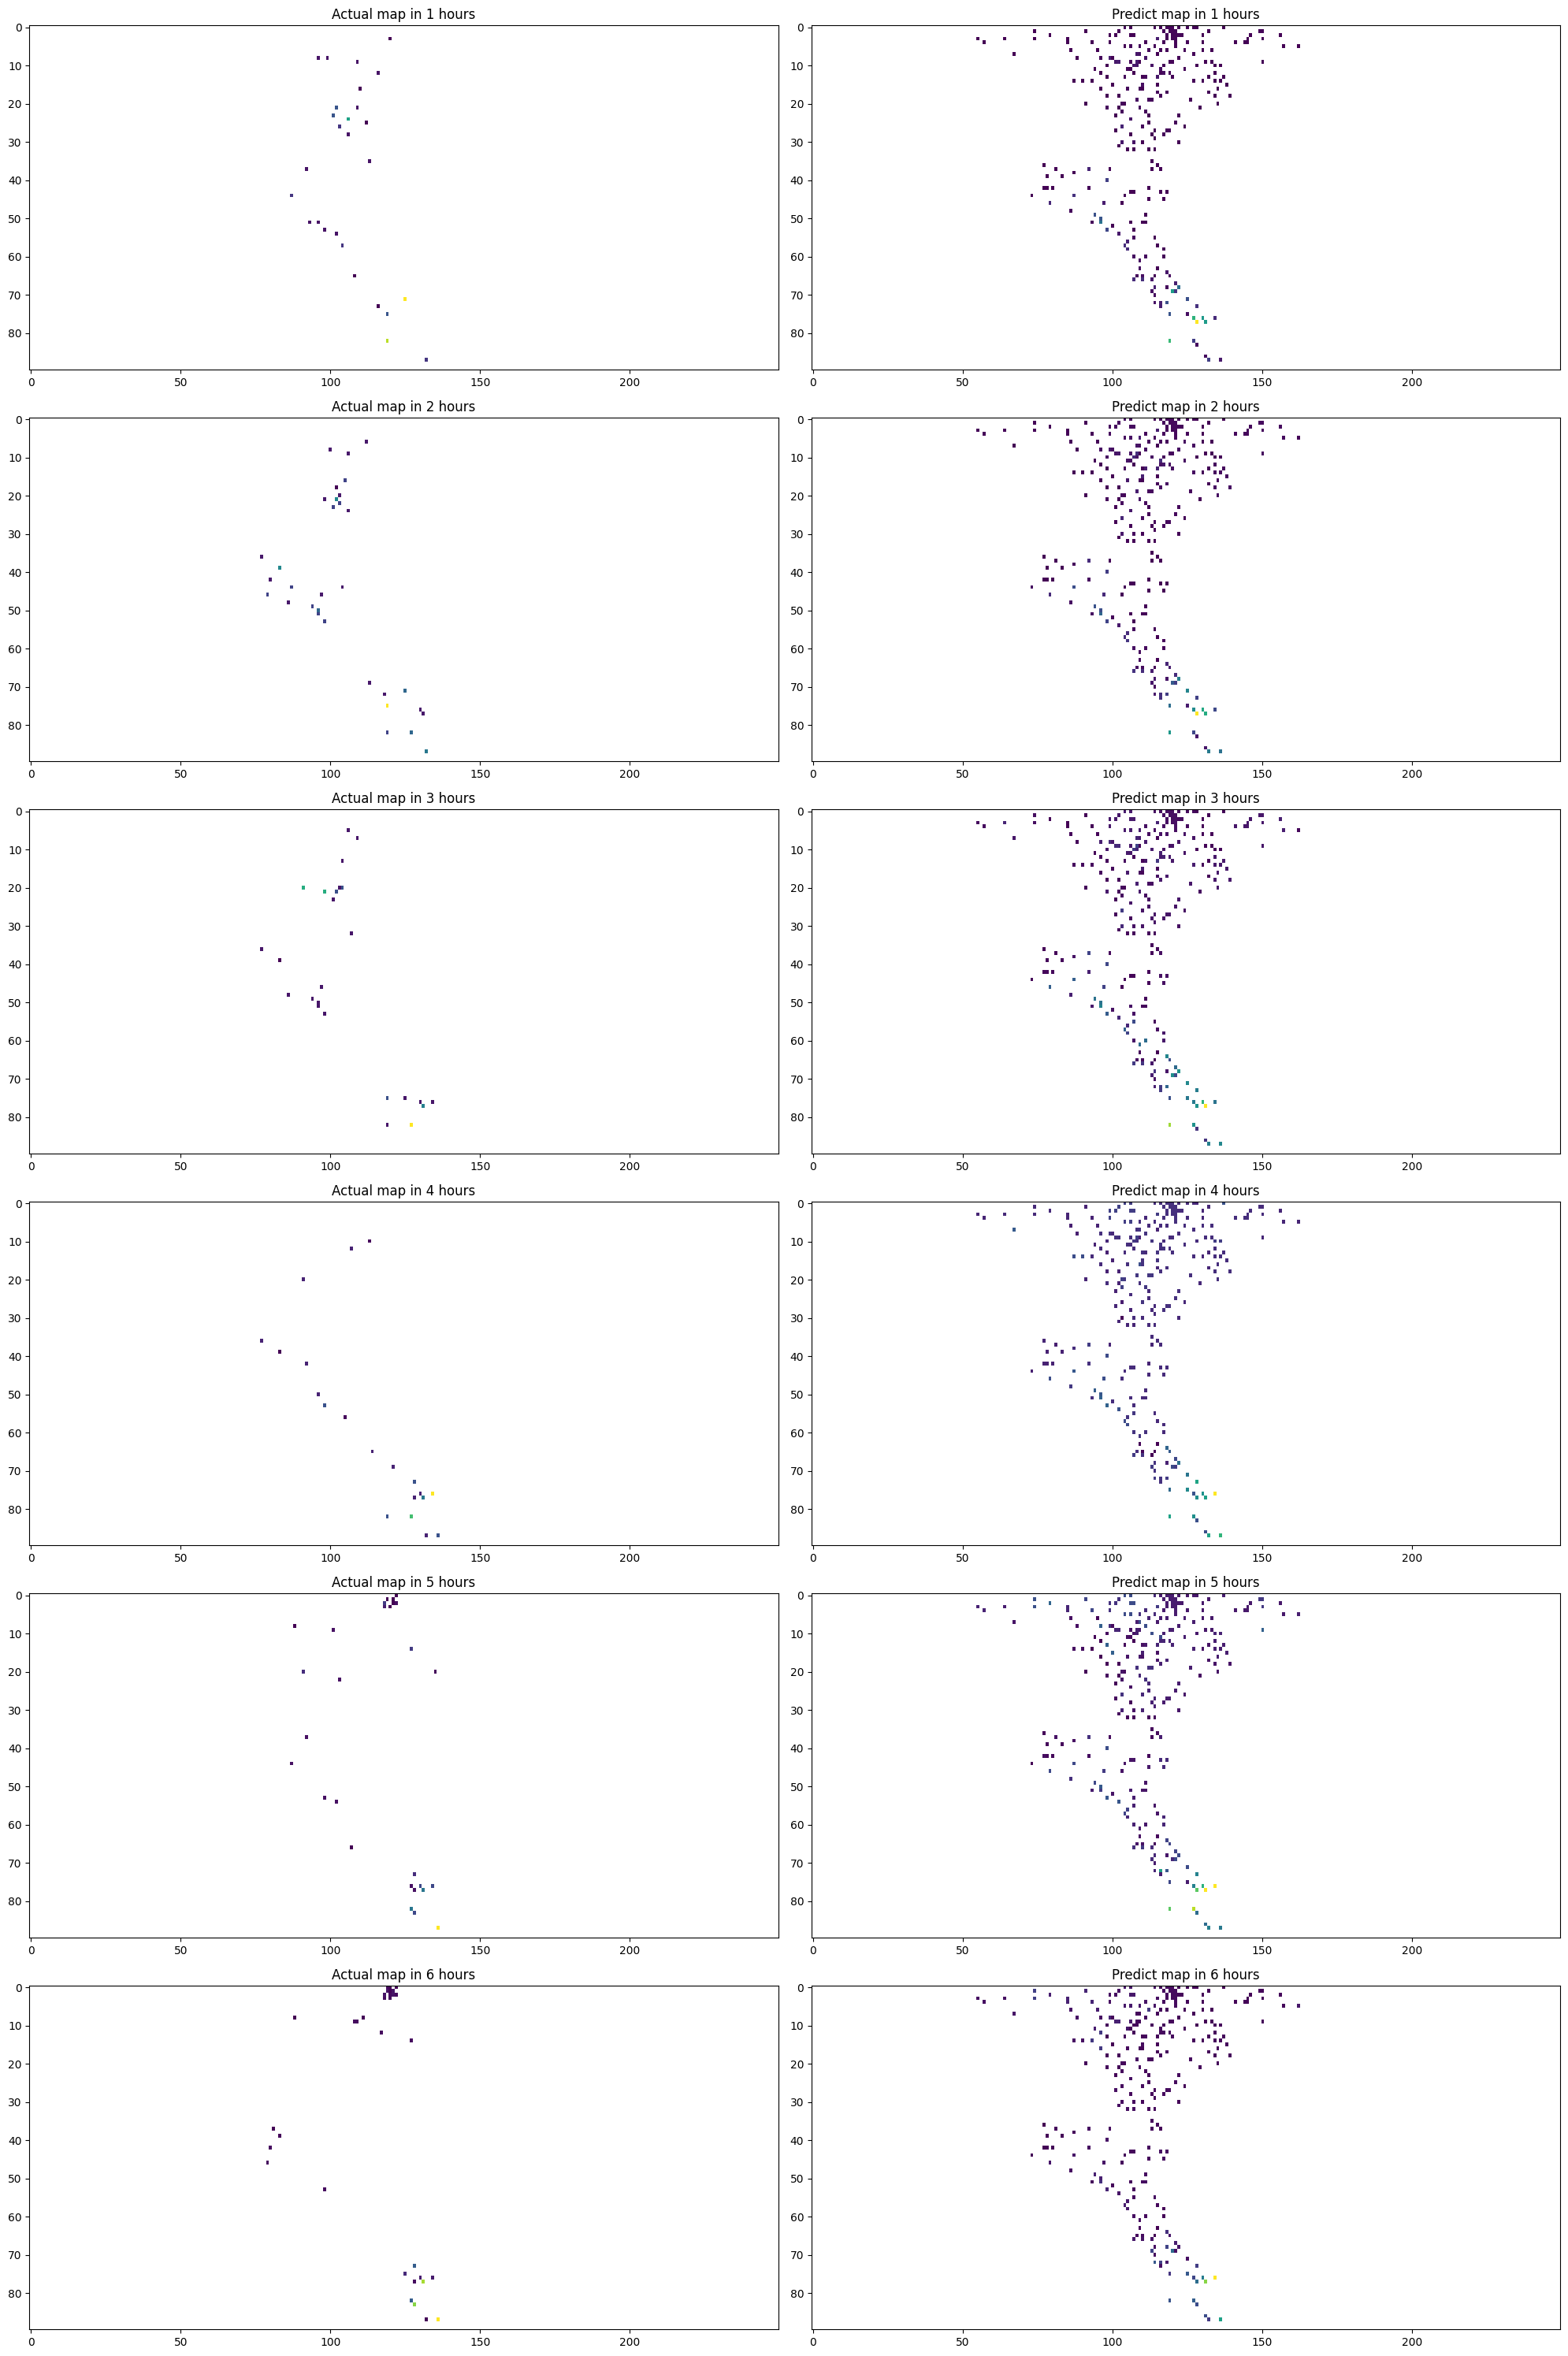

In [ ]:
tmp_cor = [(x//WIDTH, x%WIDTH) for x in range(WIDTH*HEIGHT)] 
# print(tmp_cor)
tmp_data = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
for i in range(10,10 + pre_time_step + aft_time_step):
    read(i,31,10,2020,opt_file_name_path,tmp_cor,tmp_data)
predict_map = np.zeros((aft_time_step,90,250)) 
actual_map = np.zeros((aft_time_step,90,250)) 
# print(actual_map.shape)
for i in range(HEIGHT):
    for j in range(WIDTH):
        if(len(tmp_data[i][j])==pre_time_step+aft_time_step):
            X_ex = np.array(tmp_data[i][j][:pre_time_step])[:,1:].reshape(1,-1)
            y_ex = np.array(tmp_data[i][j][pre_time_step:])[:,1].reshape(1,-1)
            # print(X_ex[0][0],X_ex[0][10],X_ex[0][20])
            
            y_predex = load_model.predict(X_ex)
            # print(X_ex.shape,y_ex.shape, y_predex.shape, aft_time_step)
            for z in range(aft_time_step):
                predict_map[z][i][j] = y_predex[0][z]
                actual_map[z][i][j] = y_ex[0][z]
        # print(tmp_data[i][j])

predict_map[predict_map == 0] = np.nan
actual_map[actual_map == 0] = np.nan
# cmap = plt.cm.viridis  
# cmap = cmap(np.arange(cmap.N))  
# cmap[0] = np.array([1, 1, 1, 1]) 
# cmap = mcolors.ListedColormap(cmap)
fig, axes = plt.subplots(aft_time_step, 2, figsize=(20, 5 * aft_time_step))
for i in range(0, aft_time_step):
    axes[i, 0].imshow(actual_map[i], cmap='viridis', aspect='auto')
    axes[i, 0].set_title(f'Actual map in {i+1} hours')
    
    axes[i, 1].imshow(predict_map[i], cmap='viridis', aspect='auto')
    axes[i, 1].set_title(f'Predict map in {i+1} hours')
    
    # print(predict_map[i]!=np.nan)
    # non_nan_indices = np.where(~np.isnan(predict_map))[0]
    # print(non_nan_indices)

print(predict_map[0][0][0])
# if predict_map[0][0][0] is not np.nan:
    # print('no')
for i in range(HEIGHT):
    for j in range(WIDTH):
        # if predict_map[0][i][j] == predict_map[1][i][j]:
            # print(i,j)
        if ~np.isnan(predict_map[0][i][j]) :
            print(i,j)
        if ~np.isnan(predict_map[1][i][j]) :
            print(i,j)

for i in range(HEIGHT):
    for j in range(WIDTH):
        # if predict_map[0][i][j] == predict_map[1][i][j]:
            # print(i,j)
        

plt.tight_layout()  
plt.show()           
# print(X_ex.shape,y_ex.shape)